# 🏀 Random Forest Model for March Madness Predictions

This notebook implements and tunes a Random Forest model for predicting NCAA March Madness tournament outcomes. It includes feature selection, hyperparameter optimization with Optuna, and model evaluation using time-based cross-validation.

## 1. Setup and Data Preparation

In [1]:
# --------------------------------------------- Imports and Configurations ---------------------------------------------
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import brier_score_loss, log_loss
import optuna

# Suppress warnings
warnings.filterwarnings("ignore")

# Enable more readable display for DataFrames
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Adjust path based on environment
if os.path.exists('/kaggle/input'):
    sys.path.append('/kaggle/input/preprocessing-module')
else:
    sys.path.append('../../scripts')

from pre_processing import build_model_pipeline, rolling_window_cv, generate_matchup_matrix

## 2. Load and Explore Dataset

In [2]:
# Load dataset using preprocessing pipeline
X, y, game_ids = build_model_pipeline(model_type='rf')
print("\nRandom Forest Dataset Summary:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"GameIDs shape: {game_ids.shape}")
print("\nClass distribution:")
print(y.value_counts())
print("\nFeature columns:")
print(X.columns.tolist())
print("\nSample features:")
print(X.head())


Random Forest Dataset Summary:
X shape: (8068, 10)
y shape: (8068,)
GameIDs shape: (8068,)

Class distribution:
Team1Wins
1    4034
0    4034
Name: count, dtype: int64

Feature columns:
['Season', 'SeedDiff', 'WinPctDiff', 'PointsForDiff', 'PointsAgainstDiff', 'AvgMarginDiff', 'Team1Games', 'Team2Games', 'Last14WinRateDiff', 'NeutralWinRateDiff']

Sample features:
   Season  SeedDiff  WinPctDiff  PointsForDiff  PointsAgainstDiff  AvgMarginDiff  Team1Games  Team2Games  Last14WinRateDiff  NeutralWinRateDiff
0    1985         1   -0.030303             64                258      -6.830303          33          30           0.250000            0.033333
1    1985         5   -0.059310            312                300      -0.110345          29          25           0.166667           -0.166667
2    1985       -15    0.546616            138               -414      20.114943          27          29           0.200000            0.500000
3    1985         1    0.062169             18          

## 3. Model Definition and Evaluation

In [3]:
def rf_model_fn(X_train, y_train, X_test, y_test, test_season, model_params, sample_weight):
    """Random Forest model function for cross-validation.
    
    Scales features, trains a Random Forest model with provided parameters,
    and returns evaluation metrics.
    """
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train model
    model = RandomForestClassifier(**model_params)
    model.fit(X_train_scaled, y_train)
    
    # Generate predictions and calculate metrics
    preds_proba = model.predict_proba(X_test_scaled)[:, 1]
    brier_val = brier_score_loss(y_test, preds_proba)
    logloss_val = log_loss(y_test, preds_proba)
    preds_class = (preds_proba >= 0.5).astype(int)
    accuracy_val = (preds_class == y_test).mean()
    
    return {'brier': brier_val, 'logloss': logloss_val, 'accuracy': accuracy_val}

In [4]:
# Extract feature names (excluding Season column)
features = [col for col in X.columns if col != 'Season']

In [5]:
# Display available features
features

['SeedDiff',
 'WinPctDiff',
 'PointsForDiff',
 'PointsAgainstDiff',
 'AvgMarginDiff',
 'Team1Games',
 'Team2Games',
 'Last14WinRateDiff',
 'NeutralWinRateDiff']

In [6]:
# Initial Random Forest parameters
rf_param = dict(
    n_estimators=209,
    max_depth=8,
    min_samples_split=16,
    random_state=42,
    class_weight='balanced'
)

## 4. Feature Selection with Forward Selection

In [7]:
# -------------------------------------------------------------
# Forward feature selection with pair, "remove-and-pair", triple look-ahead
# -------------------------------------------------------------
start_season = 2010
tol = 1e-5  # Tolerance for improvement
K_PAIRS = 6  # Top-K singles to combine into pairs

def evaluate_subset(feats, rf_param, start_season=start_season):
    """Return mean Brier score for a feature subset via rolling CV."""
    feats_with_season = ['Season'] + feats if 'Season' not in feats else feats
    X_sub = X[feats_with_season].copy()

    cv = rolling_window_cv(
        X_sub, y, start_season=start_season,
        model_fn=rf_model_fn, model_params=rf_param, verbose=False
    )
    return cv['brier'].mean() if not cv.empty else np.inf

print("⚙️  Forward selection with multi-step look-ahead")

# Initialize ---------------------------------------------------
selected = ['SeedDiff']
remaining = [f for f in features if f not in selected]
current_brier = evaluate_subset(selected, rf_param)
print(f"Initial feature Brier = {current_brier:.6f}")

last_single_added = None  # Tracks last feature added by Step-1

# Main loop ----------------------------------------------------
improved = True
while remaining and improved:
    improved = False

    # ---------------------------------------------------------
    # 1) SINGLE-FEATURE SCAN
    # ---------------------------------------------------------
    single_scores = []
    for feat in remaining:
        b = evaluate_subset(selected + [feat], rf_param)
        single_scores.append((feat, b))
        print(f"  ➕ {feat:<25} → Brier {b:.6f}")

    best_feat, best_brier = min(single_scores, key=lambda x: x[1])

    if best_brier < current_brier - tol:
        selected.append(best_feat)
        remaining.remove(best_feat)
        current_brier = best_brier
        last_single_added = best_feat
        improved = True
        print(f"✅  Added {best_feat:<25} → New Brier {current_brier:.6f}")
        continue

    # ---------------------------------------------------------
    # 2) LOOK-AHEAD WITH SEVERAL 2-FEATURE COMBINATIONS
    # ---------------------------------------------------------
    single_scores.sort(key=lambda x: x[1])  # Best singles first
    top_k = single_scores[:min(K_PAIRS, len(single_scores))]

    best_pair = None
    best_pair_brier = current_brier
    for i in range(len(top_k)):
        f1 = top_k[i][0]
        for j in range(i + 1, len(top_k)):
            f2 = top_k[j][0]
            b = evaluate_subset(selected + [f1, f2], rf_param)
            print(f"  🔍 Testing pair ({f1}, {f2}) → Brier {b:.6f}")
            if b < best_pair_brier - tol:
                best_pair_brier = b
                best_pair = (f1, f2)

    if best_pair is not None:
        selected.extend(best_pair)
        for f in best_pair:
            remaining.remove(f)
        current_brier = best_pair_brier
        last_single_added = None  # We added two at once
        improved = True
        print(f"✅  Added pair {best_pair} → New Brier {current_brier:.6f}")
        continue

    # ---------------------------------------------------------
    # 2.5) "REMOVE-AND-PAIR" LOOK-AHEAD
    # ---------------------------------------------------------
    if last_single_added is not None:
        print(f"⚗️  Trying to replace last single '{last_single_added}' with a better pair...")
        # Create candidate subset WITHOUT that last single
        candidate_selected = [f for f in selected if f != last_single_added]
        # Candidate remaining list: current remaining + the dropped feature
        candidate_remaining = remaining + [last_single_added]

        # Recompute single scores for candidate_remaining
        cand_single_scores = []
        for feat in candidate_remaining:
            b = evaluate_subset(candidate_selected + [feat], rf_param)
            cand_single_scores.append((feat, b))
        cand_single_scores.sort(key=lambda x: x[1])
        top_k_cand = cand_single_scores[:min(K_PAIRS, len(cand_single_scores))]

        best_pair2 = None
        best_pair2_brier = current_brier
        for i in range(len(top_k_cand)):
            f1 = top_k_cand[i][0]
            if f1 == last_single_added:
                continue
            for j in range(i + 1, len(top_k_cand)):
                f2 = top_k_cand[j][0]
                if f2 == last_single_added:
                    continue
                b = evaluate_subset(candidate_selected + [f1, f2], rf_param)
                print(f"  🔍 Replace-pair ({f1}, {f2}) → Brier {b:.6f}")
                if b < best_pair2_brier - tol:
                    best_pair2_brier = b
                    best_pair2 = (f1, f2)

        if best_pair2 is not None:
            # Commit the change
            selected = candidate_selected + list(best_pair2)
            # Rebuild remaining
            remaining = [f for f in candidate_remaining if f not in best_pair2]
            current_brier = best_pair2_brier
            last_single_added = None  # We removed it
            improved = True
            print(f"✅  Replaced '{last_single_added}' with pair {best_pair2} "
                  f"→ New Brier {current_brier:.6f}")
            continue

    # ---------------------------------------------------------
    # 3) LOOK-AHEAD WITH BEST 3 FEATURES
    # ---------------------------------------------------------
    if len(single_scores) >= 3:
        triple = [single_scores[i][0] for i in range(3)]
        triple_brier = evaluate_subset(selected + triple, rf_param)
        print(f"  🔍 Testing best-3 {triple} → Brier {triple_brier:.6f}")
        if triple_brier < current_brier - tol:
            selected.extend(triple)
            for f in triple:
                remaining.remove(f)
            current_brier = triple_brier
            last_single_added = None  # We added three
            improved = True
            print(f"✅  Added triple {tuple(triple)} → New Brier {current_brier:.6f}")

# Summary ------------------------------------------------------
print("\n🏁  Selection complete")
print(f"Final features ({len(selected)}): {selected}")
print(f"Final CV-Brier: {current_brier:.6f}")

⚙️  Forward selection with multi-step look-ahead
Initial feature Brier = 0.179039
  ➕ WinPctDiff                → Brier 0.179603
  ➕ PointsForDiff             → Brier 0.179004
  ➕ PointsAgainstDiff         → Brier 0.180809
  ➕ AvgMarginDiff             → Brier 0.175713
  ➕ Team1Games                → Brier 0.182039
  ➕ Team2Games                → Brier 0.182287
  ➕ Last14WinRateDiff         → Brier 0.180066
  ➕ NeutralWinRateDiff        → Brier 0.181449
✅  Added AvgMarginDiff             → New Brier 0.175713
  ➕ WinPctDiff                → Brier 0.173547
  ➕ PointsForDiff             → Brier 0.175346
  ➕ PointsAgainstDiff         → Brier 0.175033
  ➕ Team1Games                → Brier 0.176170
  ➕ Team2Games                → Brier 0.176117
  ➕ Last14WinRateDiff         → Brier 0.174869
  ➕ NeutralWinRateDiff        → Brier 0.175429
✅  Added WinPctDiff                → New Brier 0.173547
  ➕ PointsForDiff             → Brier 0.173704
  ➕ PointsAgainstDiff         → Brier 0.173967
  ➕ Tea

In [8]:
# Evaluate the Brier score using all features for comparison
evaluate_subset(features, rf_param, start_season=start_season)

np.float64(0.17447778286387264)

In [9]:
# Display the selected features
selected

['SeedDiff', 'AvgMarginDiff', 'WinPctDiff', 'Team2Games', 'Team1Games']

In [10]:
# Update dataset to include only selected features plus Season
feats_with_season = ['Season'] + selected if 'Season' not in selected else selected
X = X[feats_with_season]
X

,Season,SeedDiff,AvgMarginDiff,WinPctDiff,Team2Games,Team1Games
0,1985,1,-6.830303,-0.030303,30,33
1,1985,5,-0.110345,-0.059310,25,29
2,1985,-15,20.114943,0.546616,29,27
3,1985,1,2.177249,0.062169,28,27
4,1985,-11,1.077778,0.025926,27,30
...,...,...,...,...,...,...
8063,2023,1,-20.246976,-0.193548,32,31
8064,2023,2,-2.951613,-0.089718,31,32
8065,2023,-1,14.156250,0.187500,32,32
8066,2023,-2,-10.915054,-0.062366,30,31


## 5. Hyperparameter Tuning with Optuna

In [11]:
def objective(trial, X, y, start_season, window_size):
    """Optuna objective function for hyperparameter optimization."""
    # Define hyperparameter search space
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 5, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    
    rf_params = dict(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42,
        class_weight='balanced'
    )
    
    # Use the rolling_window_cv from pre_processing.py
    metrics_df = rolling_window_cv(
        X, y, start_season=start_season, window_size=window_size,
        model_fn=rf_model_fn, model_params=rf_params, verbose=False
    )
    if metrics_df.empty:
        return float('inf')
    return metrics_df['brier'].mean()

def tune_hyperparameters_for_window_size(X, y, start_season, window_size, n_trials=20):
    """Tunes hyperparameters for a specific window size."""
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, X, y, start_season, window_size), n_trials=n_trials)
    best_params = study.best_trial.params
    best_value = study.best_trial.value
    print(f"Best hyperparameters for window_size={window_size}: {best_params}, with avg Brier = {best_value:.4f}")
    return best_params, best_value

def grid_search_window_size_and_hyperparams(X, y, start_season, window_sizes, n_trials=20):
    """Performs grid search over window sizes and tunes hyperparameters for each."""
    records = []
    best_overall = None
    best_window = None
    best_params_overall = None
    
    for w in window_sizes:
        print(f"\nTuning for window_size = {w}")
        best_params, avg_brier = tune_hyperparameters_for_window_size(X, y, start_season, window_size=w, n_trials=n_trials)
        records.append({'window_size': w, 'avg_brier': avg_brier, 'best_params': best_params})
        if best_overall is None or avg_brier <= best_overall:
            best_overall = avg_brier
            best_window = w
            best_params_overall = best_params
    
    results_df = pd.DataFrame(records)
    print("\nGrid search results:")
    print(results_df)
    print(f"\nBest overall: window_size = {best_window}, avg Brier = {best_overall:.4f}, best_params = {best_params_overall}")
    return best_window, best_params_overall, results_df

# Use all available seasons for demonstration
demo_seasons = list(range(X['Season'].min(), X['Season'].max()+1))

# Set the selected features for the input data
X = X[feats_with_season]

# Determine maximum possible window size
max_window_size = len(demo_seasons)

# Create possible window sizes starting from 10, in steps of 5
possible_window_sizes = list(range(10, max_window_size, 5))

# Ensure the max_window_size is included if it's not already
if max_window_size not in possible_window_sizes:
    possible_window_sizes.append(max_window_size)

best_window, best_params, grid_results = grid_search_window_size_and_hyperparams(
    X, y, start_season=2010, window_sizes=possible_window_sizes, n_trials=20)

[I 2025-05-06 14:15:05,375] A new study created in memory with name: no-name-50cc67f3-dd66-419e-8d3a-1ebe6e886986



Tuning for window_size = 10


[I 2025-05-06 14:15:07,571] Trial 0 finished with value: 0.17885201921466795 and parameters: {'n_estimators': 69, 'max_depth': 19, 'min_samples_split': 14}. Best is trial 0 with value: 0.17885201921466795.
[I 2025-05-06 14:15:09,999] Trial 1 finished with value: 0.1779213843781777 and parameters: {'n_estimators': 81, 'max_depth': 10, 'min_samples_split': 7}. Best is trial 1 with value: 0.1779213843781777.
[I 2025-05-06 14:15:11,244] Trial 2 finished with value: 0.17539443474224514 and parameters: {'n_estimators': 58, 'max_depth': 5, 'min_samples_split': 7}. Best is trial 2 with value: 0.17539443474224514.
[I 2025-05-06 14:15:18,252] Trial 3 finished with value: 0.17607950120786825 and parameters: {'n_estimators': 260, 'max_depth': 9, 'min_samples_split': 10}. Best is trial 2 with value: 0.17539443474224514.
[I 2025-05-06 14:15:20,276] Trial 4 finished with value: 0.18235542681945013 and parameters: {'n_estimators': 60, 'max_depth': 18, 'min_samples_split': 6}. Best is trial 2 with valu

Best hyperparameters for window_size=10: {'n_estimators': 251, 'max_depth': 7, 'min_samples_split': 20}, with avg Brier = 0.1746

Tuning for window_size = 15


[I 2025-05-06 14:16:59,790] Trial 0 finished with value: 0.17740846114303785 and parameters: {'n_estimators': 238, 'max_depth': 12, 'min_samples_split': 2}. Best is trial 0 with value: 0.17740846114303785.
[I 2025-05-06 14:17:08,992] Trial 1 finished with value: 0.17651776569014604 and parameters: {'n_estimators': 197, 'max_depth': 19, 'min_samples_split': 16}. Best is trial 1 with value: 0.17651776569014604.
[I 2025-05-06 14:17:12,907] Trial 2 finished with value: 0.17394772231509764 and parameters: {'n_estimators': 117, 'max_depth': 7, 'min_samples_split': 8}. Best is trial 2 with value: 0.17394772231509764.
[I 2025-05-06 14:17:24,002] Trial 3 finished with value: 0.17364825338108256 and parameters: {'n_estimators': 294, 'max_depth': 8, 'min_samples_split': 14}. Best is trial 3 with value: 0.17364825338108256.
[I 2025-05-06 14:17:30,837] Trial 4 finished with value: 0.17432913932598929 and parameters: {'n_estimators': 209, 'max_depth': 6, 'min_samples_split': 15}. Best is trial 3 wit

Best hyperparameters for window_size=15: {'n_estimators': 60, 'max_depth': 8, 'min_samples_split': 20}, with avg Brier = 0.1735

Tuning for window_size = 20


[I 2025-05-06 14:19:29,172] Trial 0 finished with value: 0.1794160483058101 and parameters: {'n_estimators': 298, 'max_depth': 15, 'min_samples_split': 4}. Best is trial 0 with value: 0.1794160483058101.
[I 2025-05-06 14:19:39,019] Trial 1 finished with value: 0.1738758718111077 and parameters: {'n_estimators': 242, 'max_depth': 8, 'min_samples_split': 14}. Best is trial 1 with value: 0.1738758718111077.
[I 2025-05-06 14:19:42,174] Trial 2 finished with value: 0.17556636638520423 and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 17}. Best is trial 1 with value: 0.1738758718111077.
[I 2025-05-06 14:19:51,368] Trial 3 finished with value: 0.17972796503679128 and parameters: {'n_estimators': 143, 'max_depth': 14, 'min_samples_split': 3}. Best is trial 1 with value: 0.1738758718111077.
[I 2025-05-06 14:20:01,449] Trial 4 finished with value: 0.17415810304495644 and parameters: {'n_estimators': 260, 'max_depth': 6, 'min_samples_split': 7}. Best is trial 1 with value

Best hyperparameters for window_size=20: {'n_estimators': 251, 'max_depth': 7, 'min_samples_split': 10}, with avg Brier = 0.1735

Tuning for window_size = 25


[I 2025-05-06 14:22:50,639] Trial 0 finished with value: 0.17464271376435533 and parameters: {'n_estimators': 143, 'max_depth': 9, 'min_samples_split': 10}. Best is trial 0 with value: 0.17464271376435533.
[I 2025-05-06 14:23:04,101] Trial 1 finished with value: 0.17822146310844608 and parameters: {'n_estimators': 192, 'max_depth': 16, 'min_samples_split': 12}. Best is trial 0 with value: 0.17464271376435533.
[I 2025-05-06 14:23:17,928] Trial 2 finished with value: 0.17478117611176633 and parameters: {'n_estimators': 264, 'max_depth': 9, 'min_samples_split': 4}. Best is trial 0 with value: 0.17464271376435533.
[I 2025-05-06 14:23:32,117] Trial 3 finished with value: 0.1773293994311234 and parameters: {'n_estimators': 230, 'max_depth': 19, 'min_samples_split': 15}. Best is trial 0 with value: 0.17464271376435533.
[I 2025-05-06 14:23:43,564] Trial 4 finished with value: 0.17494594510364836 and parameters: {'n_estimators': 203, 'max_depth': 10, 'min_samples_split': 19}. Best is trial 0 wi

Best hyperparameters for window_size=25: {'n_estimators': 148, 'max_depth': 7, 'min_samples_split': 6}, with avg Brier = 0.1736

Tuning for window_size = 30


[I 2025-05-06 14:25:36,481] Trial 0 finished with value: 0.1750715701714844 and parameters: {'n_estimators': 54, 'max_depth': 10, 'min_samples_split': 17}. Best is trial 0 with value: 0.1750715701714844.
[I 2025-05-06 14:25:43,072] Trial 1 finished with value: 0.1770491941391848 and parameters: {'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 8}. Best is trial 0 with value: 0.1750715701714844.
[I 2025-05-06 14:25:46,258] Trial 2 finished with value: 0.17426295234358277 and parameters: {'n_estimators': 56, 'max_depth': 8, 'min_samples_split': 11}. Best is trial 2 with value: 0.17426295234358277.
[I 2025-05-06 14:26:02,000] Trial 3 finished with value: 0.17353054375128898 and parameters: {'n_estimators': 268, 'max_depth': 9, 'min_samples_split': 20}. Best is trial 3 with value: 0.17353054375128898.
[I 2025-05-06 14:26:19,723] Trial 4 finished with value: 0.17797294053868445 and parameters: {'n_estimators': 240, 'max_depth': 19, 'min_samples_split': 11}. Best is trial 3 with va

Best hyperparameters for window_size=30: {'n_estimators': 100, 'max_depth': 7, 'min_samples_split': 9}, with avg Brier = 0.1733

Tuning for window_size = 35


[I 2025-05-06 14:29:01,201] Trial 0 finished with value: 0.17899302246258353 and parameters: {'n_estimators': 83, 'max_depth': 16, 'min_samples_split': 6}. Best is trial 0 with value: 0.17899302246258353.
[I 2025-05-06 14:29:20,841] Trial 1 finished with value: 0.1814845290161585 and parameters: {'n_estimators': 239, 'max_depth': 19, 'min_samples_split': 3}. Best is trial 0 with value: 0.17899302246258353.
[I 2025-05-06 14:29:27,680] Trial 2 finished with value: 0.1770614564108753 and parameters: {'n_estimators': 91, 'max_depth': 14, 'min_samples_split': 10}. Best is trial 2 with value: 0.1770614564108753.
[I 2025-05-06 14:29:35,290] Trial 3 finished with value: 0.1732429681206011 and parameters: {'n_estimators': 136, 'max_depth': 8, 'min_samples_split': 9}. Best is trial 3 with value: 0.1732429681206011.
[I 2025-05-06 14:29:50,934] Trial 4 finished with value: 0.1742504764071074 and parameters: {'n_estimators': 239, 'max_depth': 12, 'min_samples_split': 19}. Best is trial 3 with value

Best hyperparameters for window_size=35: {'n_estimators': 248, 'max_depth': 7, 'min_samples_split': 4}, with avg Brier = 0.1731

Tuning for window_size = 39


[I 2025-05-06 14:32:46,285] Trial 0 finished with value: 0.17633751545856746 and parameters: {'n_estimators': 283, 'max_depth': 15, 'min_samples_split': 12}. Best is trial 0 with value: 0.17633751545856746.
[I 2025-05-06 14:32:51,892] Trial 1 finished with value: 0.1742626213073518 and parameters: {'n_estimators': 88, 'max_depth': 13, 'min_samples_split': 18}. Best is trial 1 with value: 0.1742626213073518.
[I 2025-05-06 14:32:57,746] Trial 2 finished with value: 0.17769540320994393 and parameters: {'n_estimators': 77, 'max_depth': 20, 'min_samples_split': 14}. Best is trial 1 with value: 0.1742626213073518.
[I 2025-05-06 14:33:02,271] Trial 3 finished with value: 0.17452791880029905 and parameters: {'n_estimators': 60, 'max_depth': 12, 'min_samples_split': 18}. Best is trial 1 with value: 0.1742626213073518.
[I 2025-05-06 14:33:08,373] Trial 4 finished with value: 0.17337486248784734 and parameters: {'n_estimators': 123, 'max_depth': 6, 'min_samples_split': 14}. Best is trial 4 with v

Best hyperparameters for window_size=39: {'n_estimators': 230, 'max_depth': 7, 'min_samples_split': 11}, with avg Brier = 0.1728

Grid search results:
   window_size  avg_brier                                        best_params
0           10   0.174559  {'n_estimators': 251, 'max_depth': 7, 'min_sam...
1           15   0.173484  {'n_estimators': 60, 'max_depth': 8, 'min_samp...
2           20   0.173542  {'n_estimators': 251, 'max_depth': 7, 'min_sam...
3           25   0.173610  {'n_estimators': 148, 'max_depth': 7, 'min_sam...
4           30   0.173297  {'n_estimators': 100, 'max_depth': 7, 'min_sam...
5           35   0.173077  {'n_estimators': 248, 'max_depth': 7, 'min_sam...
6           39   0.172844  {'n_estimators': 230, 'max_depth': 7, 'min_sam...

Best overall: window_size = 39, avg Brier = 0.1728, best_params = {'n_estimators': 230, 'max_depth': 7, 'min_samples_split': 11}


## 6. Model Evaluation with Optimal Parameters

In [12]:
print(f"\nFinal evaluation with best window size = {best_window} and best hyperparameters = {best_params}")
final_metrics_df = rolling_window_cv(
    X, y, start_season=2010, window_size=best_window,
    model_fn=rf_model_fn, model_params=best_params, verbose=True
)


Final evaluation with best window size = 39 and best hyperparameters = {'n_estimators': 230, 'max_depth': 7, 'min_samples_split': 11}
Season 2011 – Accuracy: 0.681, Log Loss: 0.516, Brier: 0.178
Season 2012 – Accuracy: 0.781, Log Loss: 0.509, Brier: 0.166
Season 2013 – Accuracy: 0.715, Log Loss: 0.538, Brier: 0.184
Season 2014 – Accuracy: 0.727, Log Loss: 0.514, Brier: 0.176
Season 2015 – Accuracy: 0.788, Log Loss: 0.463, Brier: 0.149
Season 2016 – Accuracy: 0.719, Log Loss: 0.535, Brier: 0.181
Season 2017 – Accuracy: 0.788, Log Loss: 0.485, Brier: 0.162
Season 2018 – Accuracy: 0.692, Log Loss: 0.558, Brier: 0.189
Season 2019 – Accuracy: 0.738, Log Loss: 0.462, Brier: 0.155
Season 2021 – Accuracy: 0.717, Log Loss: 0.562, Brier: 0.191

Overall average metrics: Accuracy: 0.735, Log Loss: 0.514, Brier: 0.173


## 7. Feature Importance Analysis


Final evaluation using all available training data:
Season 2011 – Accuracy: 0.692, Log Loss: 0.511, Brier: 0.176
Season 2012 – Accuracy: 0.765, Log Loss: 0.509, Brier: 0.167
Season 2013 – Accuracy: 0.712, Log Loss: 0.537, Brier: 0.184
Season 2014 – Accuracy: 0.735, Log Loss: 0.514, Brier: 0.176
Season 2015 – Accuracy: 0.781, Log Loss: 0.464, Brier: 0.150
Season 2016 – Accuracy: 0.731, Log Loss: 0.533, Brier: 0.180
Season 2017 – Accuracy: 0.792, Log Loss: 0.490, Brier: 0.164
Season 2018 – Accuracy: 0.692, Log Loss: 0.557, Brier: 0.188
Season 2019 – Accuracy: 0.738, Log Loss: 0.460, Brier: 0.155
Season 2021 – Accuracy: 0.705, Log Loss: 0.570, Brier: 0.194

Overall average metrics: Accuracy: 0.734, Log Loss: 0.515, Brier: 0.173

Top 5 most important features:
         feature  importance
0       SeedDiff    0.511106
1  AvgMarginDiff    0.271625
2     WinPctDiff    0.135290
4     Team1Games    0.042462
3     Team2Games    0.039517


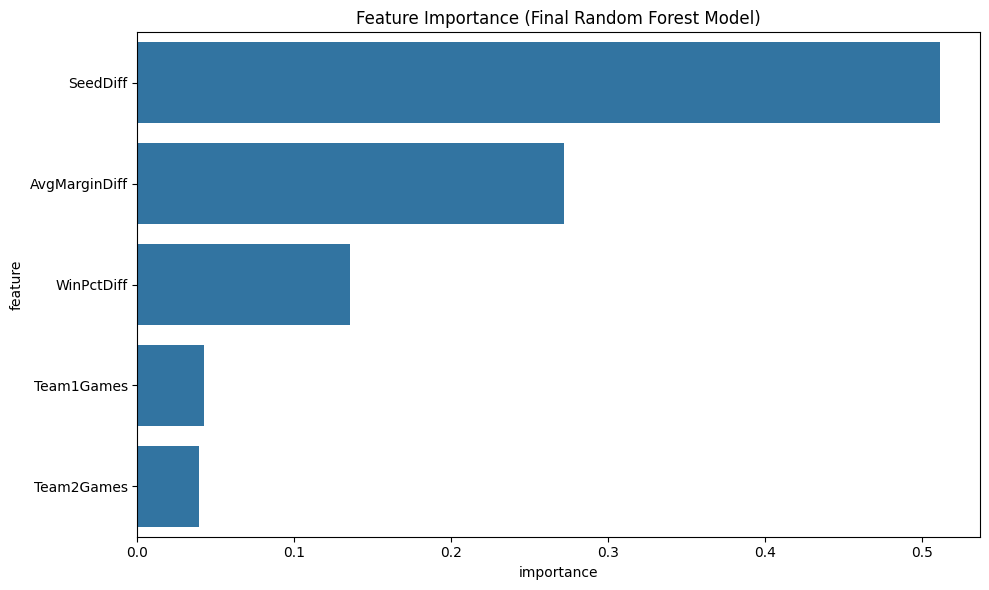

In [13]:
print("\nFinal evaluation using all available training data:")
final_metrics_all_df = rolling_window_cv(
    X, y, start_season=2010, window_size=None,
    model_fn=rf_model_fn, model_params=best_params, verbose=True
)

# Train final model on all data from seasons >= start_season
train_mask = X['Season'] >= 2011
X_final = X[train_mask].drop(columns=['Season'])
y_final = y[train_mask]

# Scale features
scaler = StandardScaler()
X_final_scaled = scaler.fit_transform(X_final)

# Train final model
final_model = RandomForestClassifier(**best_params)
final_model.fit(X_final_scaled, y_final)

# Compute and visualize feature importances
feature_importance = pd.DataFrame({
    'feature': X_final.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 5 most important features:")
print(feature_importance.head(5))

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance (Final Random Forest Model)')
plt.tight_layout()
plt.show()

## 8. Generate Tournament Predictions

In [14]:
# ------------------------------------------------------------------
# Set up output directory for predictions
# ------------------------------------------------------------------
if os.path.exists('/kaggle/input'):
    preds_dir = Path('/kaggle/working/predictions')
else:
    project_root = Path(os.getcwd()).parent.parent
    preds_dir = project_root / "predictions"

# Make sure the directory exists
preds_dir.mkdir(exist_ok=True, parents=True)

# ------------------------------------------------------------------
# Set model parameters from earlier optimization
# ------------------------------------------------------------------
rf_features = selected  # Final feature set (no "Season")
base_params = best_params.copy()  # Best Optuna hyper-params
window_size = best_window  # Best look-back window (may be None)

# ------------------------------------------------------------------
# Generate predictions for each tournament season
# ------------------------------------------------------------------
for season in (2022, 2023, 2024):
    # Train on the appropriate look-back window
    if window_size is None:
        train_mask = X["Season"] < season
    else:
        train_mask = (X["Season"] < season) & (X["Season"] >= season - window_size - 1)

    X_train_raw = X.loc[train_mask, rf_features]
    y_train = y.loc[train_mask]

    # Scale features
    scaler = StandardScaler().fit(X_train_raw)
    X_train = scaler.transform(X_train_raw)

    # Train model
    clf = RandomForestClassifier(**base_params).fit(X_train, y_train)

    # Generate predictions for both men's and women's tournaments
    all_dfs = []
    for gender in ("M", "W"):
        X_pred_raw, game_ids = generate_matchup_matrix("rf", season, gender=gender)
        X_pred_scaled = scaler.transform(X_pred_raw[rf_features])

        y_hat = clf.predict_proba(X_pred_scaled)[:, 1]
        all_dfs.append(pd.DataFrame({
            "Season": season,
            "GameID": game_ids,
            "y_hat_proba": y_hat,
        }))

    # Save predictions to file
    df_out = pd.concat(all_dfs, ignore_index=True)
    out_f = preds_dir / f"predictions_{season}_rf.csv"
    df_out.to_csv(out_f, index=False)

    n_train = train_mask.sum()
    print(f"{season}: trained on {n_train:>4} rows → {len(df_out):>4} preds  |  saved → {out_f}")

2022: trained on 7532 rows → 4556 preds  |  saved → /home/benc/projects/ML-final/predictions/predictions_2022_rf.csv
2023: trained on 7800 rows → 4556 preds  |  saved → /home/benc/projects/ML-final/predictions/predictions_2023_rf.csv
2024: trained on 8068 rows → 4556 preds  |  saved → /home/benc/projects/ML-final/predictions/predictions_2024_rf.csv
